In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import stft
from pzData import pzNpz
from ezPzModels import ezPzLSTM

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("CPU")

cuda


In [3]:
train_labels = "./data/train_labels.csv"
test_labels = "./data/test_labels.csv"
val_labels = "./data/val_labels.csv"
val_dir = test_dir = train_dir = "./data/raw/"

CROP = 12000
cut = lambda x: x[:CROP]

def stfourier(x):
    freq = len(x) // 3.0
    f, t, Zxx = stft(x[:, :CROP], fs=freq, nperseg=100, noverlap=50)
    return np.asarray([f, t, Zxx])

def fourier(x):
    t = x[0, 1000:CROP+1000]
    d = np.fft.fft(x[1, 1000:CROP+1000])
    return np.asarray([t, d])


train_dataset = pzNpz(train_labels, train_dir, transform=fourier)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = pzNpz(test_labels, test_dir, transform=fourier)
test_loader = DataLoader(test_dataset, batch_size=10)

val_dataset = pzNpz(val_labels, val_dir, transform=fourier)
val_loader = DataLoader(val_dataset, batch_size=10)

In [4]:
# model parameters
input_size = CROP
# for now, this is only a binary classification task
num_classes = 2

In [5]:
def train_lstm(hidden_size, num_layers, learning_rate, dropout=0.0, optim=torch.optim.Adam, num_epochs=10):

    model = ezPzLSTM(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = criterion(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        train_losses.append(running_loss / len(train_loader))

        model.eval()

        predicted_y = []
        true_y = []
        val_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x = val_x.to(device=device, dtype=torch.float32)
                val_y = val_y.to(device=device, dtype=torch.long)
                val_scores = model(val_x)
                _, preds = torch.max(val_scores, 1)
                val_scores = model(val_x)
                val_loss += criterion(val_scores, val_y).item()

                if device != torch.device('cpu'):
                    predicted_y.extend(preds.cpu().numpy())
                    true_y.extend(val_y.cpu().numpy())
                else:
                    predicted_y.extend(preds.numpy())
                    true_y.extend(val_y.numpy())
            
            val_accuracy = accuracy_score(true_y, predicted_y)
            average_val_loss = val_loss / len(val_loader)
            val_losses.append(average_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.5f}, Val Acc: {val_accuracy:.2%}")

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return val_accuracy

Epoch [1/10], Loss: 0.69259, Val Acc: 52.94%
Epoch [2/10], Loss: 0.66541, Val Acc: 52.94%
Epoch [3/10], Loss: 0.65817, Val Acc: 52.94%
Epoch [4/10], Loss: 0.53007, Val Acc: 52.94%
Epoch [5/10], Loss: 0.43872, Val Acc: 47.06%
Epoch [6/10], Loss: 0.27504, Val Acc: 50.00%
Epoch [7/10], Loss: 0.13036, Val Acc: 47.06%
Epoch [8/10], Loss: 0.03807, Val Acc: 50.00%
Epoch [9/10], Loss: 0.01119, Val Acc: 52.94%
Epoch [10/10], Loss: 0.00457, Val Acc: 50.00%


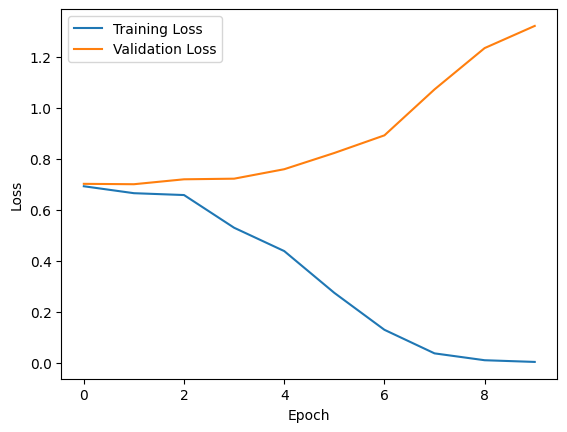

ACCURACY 128, 2, 0.001, 0.2, <class 'torch.optim.adam.Adam'>:  50.000%
Epoch [1/10], Loss: 0.71356, Val Acc: 52.94%
Epoch [2/10], Loss: 0.68513, Val Acc: 52.94%
Epoch [3/10], Loss: 0.65246, Val Acc: 52.94%
Epoch [4/10], Loss: 0.58374, Val Acc: 52.94%
Epoch [5/10], Loss: 0.58688, Val Acc: 52.94%
Epoch [6/10], Loss: 0.50280, Val Acc: 50.00%
Epoch [7/10], Loss: 0.37302, Val Acc: 38.24%
Epoch [8/10], Loss: 0.21219, Val Acc: 44.12%
Epoch [9/10], Loss: 0.10231, Val Acc: 44.12%
Epoch [10/10], Loss: 0.03821, Val Acc: 47.06%


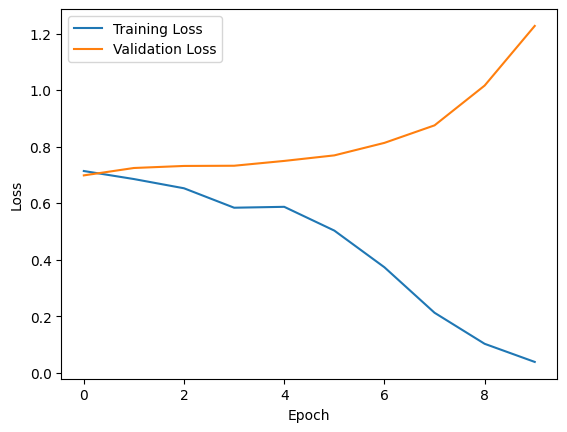

ACCURACY 128, 2, 0.001, 0.4, <class 'torch.optim.adam.Adam'>:  47.059%
Epoch [1/10], Loss: 0.72165, Val Acc: 52.94%
Epoch [2/10], Loss: 0.67612, Val Acc: 52.94%
Epoch [3/10], Loss: 0.67513, Val Acc: 52.94%
Epoch [4/10], Loss: 0.63342, Val Acc: 52.94%
Epoch [5/10], Loss: 0.59801, Val Acc: 52.94%
Epoch [6/10], Loss: 0.57394, Val Acc: 52.94%
Epoch [7/10], Loss: 0.46257, Val Acc: 50.00%
Epoch [8/10], Loss: 0.38094, Val Acc: 52.94%
Epoch [9/10], Loss: 0.23145, Val Acc: 52.94%
Epoch [10/10], Loss: 0.13791, Val Acc: 52.94%


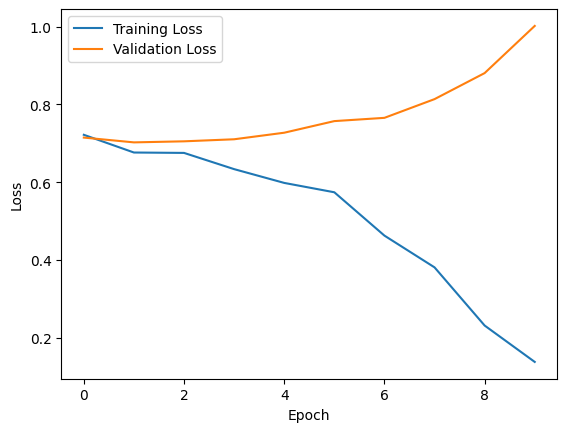

ACCURACY 128, 2, 0.001, 0.6, <class 'torch.optim.adam.Adam'>:  52.941%
Epoch [1/10], Loss: 0.68952, Val Acc: 52.94%
Epoch [2/10], Loss: 0.69675, Val Acc: 52.94%
Epoch [3/10], Loss: 0.65774, Val Acc: 52.94%
Epoch [4/10], Loss: 0.63260, Val Acc: 52.94%
Epoch [5/10], Loss: 0.67139, Val Acc: 52.94%
Epoch [6/10], Loss: 0.63732, Val Acc: 52.94%
Epoch [7/10], Loss: 0.61491, Val Acc: 52.94%
Epoch [8/10], Loss: 0.62829, Val Acc: 52.94%
Epoch [9/10], Loss: 0.57293, Val Acc: 52.94%
Epoch [10/10], Loss: 0.47315, Val Acc: 44.12%


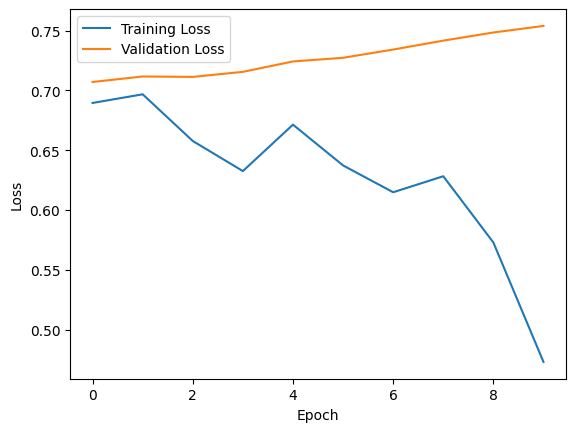

ACCURACY 128, 2, 0.001, 0.8, <class 'torch.optim.adam.Adam'>:  44.118%
Epoch [1/10], Loss: 0.70350, Val Acc: 52.94%
Epoch [2/10], Loss: 0.64670, Val Acc: 52.94%
Epoch [3/10], Loss: 0.55099, Val Acc: 52.94%
Epoch [4/10], Loss: 0.38194, Val Acc: 47.06%
Epoch [5/10], Loss: 0.15773, Val Acc: 47.06%
Epoch [6/10], Loss: 0.02560, Val Acc: 50.00%
Epoch [7/10], Loss: 0.00321, Val Acc: 52.94%
Epoch [8/10], Loss: 0.00080, Val Acc: 55.88%
Epoch [9/10], Loss: 0.00028, Val Acc: 55.88%
Epoch [10/10], Loss: 0.00017, Val Acc: 55.88%


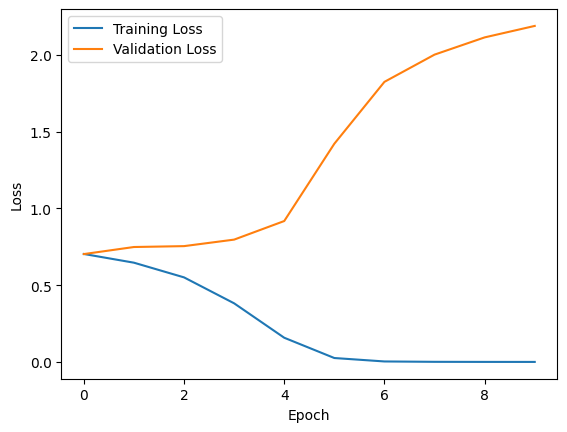

ACCURACY 128, 2, 0.002, 0.2, <class 'torch.optim.adam.Adam'>:  55.882%
Epoch [1/10], Loss: 0.69694, Val Acc: 52.94%
Epoch [2/10], Loss: 0.63090, Val Acc: 52.94%
Epoch [3/10], Loss: 0.55420, Val Acc: 52.94%
Epoch [4/10], Loss: 0.37607, Val Acc: 50.00%
Epoch [5/10], Loss: 0.14584, Val Acc: 44.12%
Epoch [6/10], Loss: 0.03198, Val Acc: 47.06%
Epoch [7/10], Loss: 0.00482, Val Acc: 52.94%
Epoch [8/10], Loss: 0.00165, Val Acc: 50.00%
Epoch [9/10], Loss: 0.00060, Val Acc: 50.00%
Epoch [10/10], Loss: 0.00023, Val Acc: 47.06%


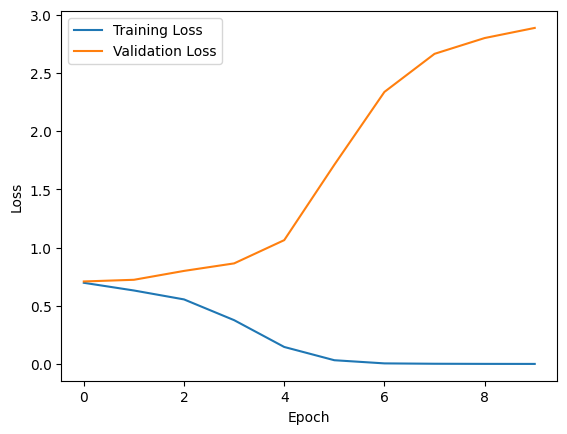

ACCURACY 128, 2, 0.002, 0.4, <class 'torch.optim.adam.Adam'>:  47.059%
Epoch [1/10], Loss: 0.68478, Val Acc: 52.94%
Epoch [2/10], Loss: 0.66228, Val Acc: 52.94%
Epoch [3/10], Loss: 0.67314, Val Acc: 52.94%
Epoch [4/10], Loss: 0.55537, Val Acc: 50.00%
Epoch [5/10], Loss: 0.45596, Val Acc: 55.88%
Epoch [6/10], Loss: 0.26189, Val Acc: 50.00%
Epoch [7/10], Loss: 0.13264, Val Acc: 50.00%
Epoch [8/10], Loss: 0.02669, Val Acc: 55.88%
Epoch [9/10], Loss: 0.10121, Val Acc: 50.00%
Epoch [10/10], Loss: 0.00454, Val Acc: 50.00%


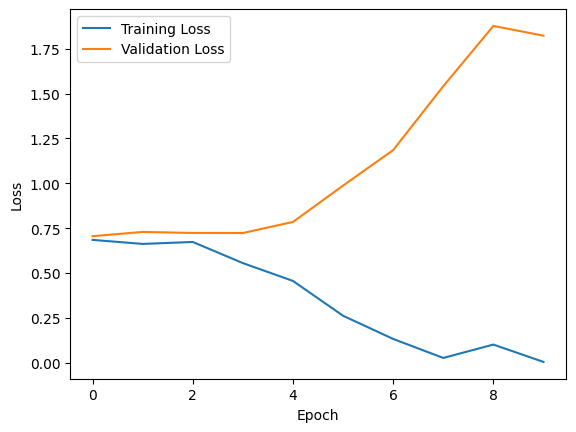

ACCURACY 128, 2, 0.002, 0.6, <class 'torch.optim.adam.Adam'>:  50.000%
Epoch [1/10], Loss: 0.71965, Val Acc: 52.94%
Epoch [2/10], Loss: 0.67142, Val Acc: 52.94%
Epoch [3/10], Loss: 0.63871, Val Acc: 52.94%
Epoch [4/10], Loss: 0.64774, Val Acc: 52.94%
Epoch [5/10], Loss: 0.66979, Val Acc: 52.94%
Epoch [6/10], Loss: 0.60738, Val Acc: 52.94%
Epoch [7/10], Loss: 0.49250, Val Acc: 52.94%
Epoch [8/10], Loss: 0.48536, Val Acc: 55.88%
Epoch [9/10], Loss: 0.33880, Val Acc: 58.82%
Epoch [10/10], Loss: 0.18663, Val Acc: 55.88%


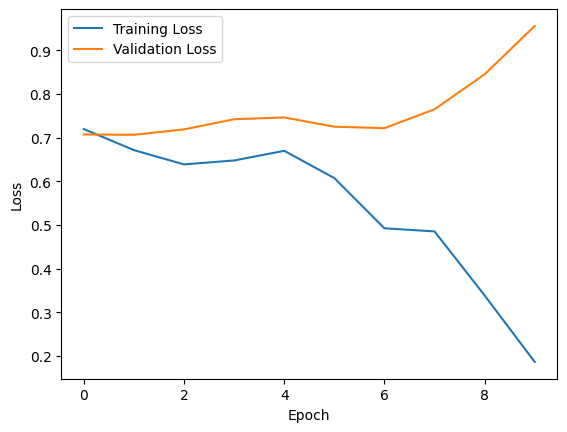

ACCURACY 128, 2, 0.002, 0.8, <class 'torch.optim.adam.Adam'>:  55.882%
Epoch [1/10], Loss: 0.70924, Val Acc: 50.00%
Epoch [2/10], Loss: 0.63301, Val Acc: 50.00%
Epoch [3/10], Loss: 0.50121, Val Acc: 50.00%
Epoch [4/10], Loss: 0.29002, Val Acc: 50.00%
Epoch [5/10], Loss: 0.07739, Val Acc: 50.00%
Epoch [6/10], Loss: 0.01100, Val Acc: 52.94%
Epoch [7/10], Loss: 0.00197, Val Acc: 55.88%
Epoch [8/10], Loss: 0.00054, Val Acc: 52.94%
Epoch [9/10], Loss: 0.00017, Val Acc: 52.94%
Epoch [10/10], Loss: 0.00009, Val Acc: 55.88%


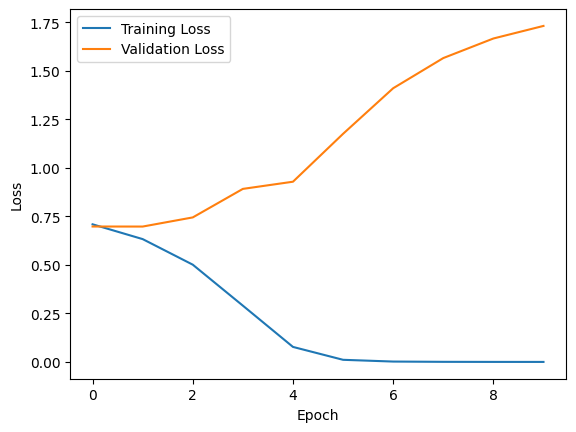

ACCURACY 256, 2, 0.001, 0.2, <class 'torch.optim.adam.Adam'>:  55.882%
Epoch [1/10], Loss: 0.71803, Val Acc: 52.94%
Epoch [2/10], Loss: 0.66216, Val Acc: 52.94%
Epoch [3/10], Loss: 0.60596, Val Acc: 52.94%
Epoch [4/10], Loss: 0.47715, Val Acc: 52.94%
Epoch [5/10], Loss: 0.26994, Val Acc: 52.94%
Epoch [6/10], Loss: 0.08959, Val Acc: 41.18%
Epoch [7/10], Loss: 0.01687, Val Acc: 47.06%
Epoch [8/10], Loss: 0.00356, Val Acc: 47.06%
Epoch [9/10], Loss: 0.00063, Val Acc: 44.12%
Epoch [10/10], Loss: 0.00032, Val Acc: 52.94%


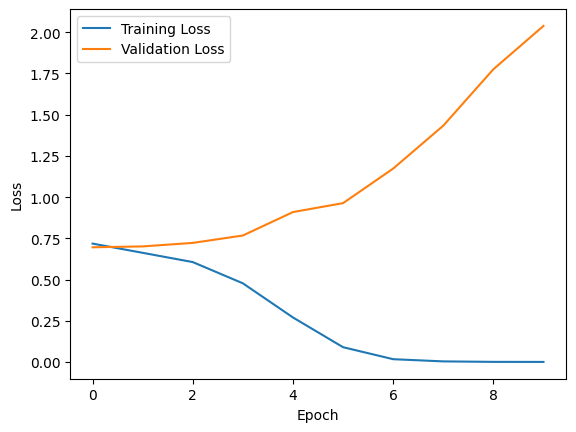

ACCURACY 256, 2, 0.001, 0.4, <class 'torch.optim.adam.Adam'>:  52.941%
Epoch [1/10], Loss: 0.71469, Val Acc: 52.94%
Epoch [2/10], Loss: 0.65152, Val Acc: 52.94%
Epoch [3/10], Loss: 0.61621, Val Acc: 52.94%
Epoch [4/10], Loss: 0.55667, Val Acc: 52.94%
Epoch [5/10], Loss: 0.36601, Val Acc: 55.88%
Epoch [6/10], Loss: 0.22189, Val Acc: 52.94%
Epoch [7/10], Loss: 0.07996, Val Acc: 47.06%
Epoch [8/10], Loss: 0.02732, Val Acc: 47.06%
Epoch [9/10], Loss: 0.00640, Val Acc: 47.06%
Epoch [10/10], Loss: 0.00354, Val Acc: 44.12%


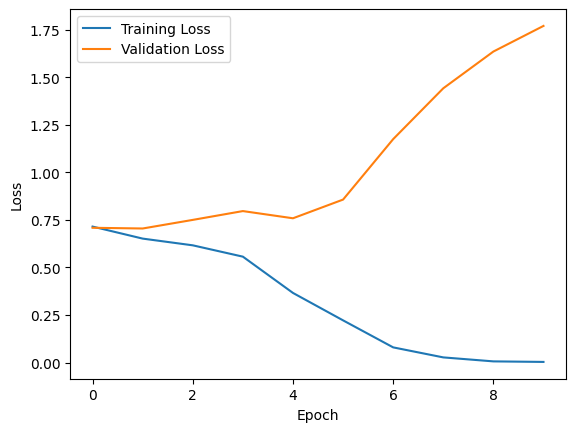

ACCURACY 256, 2, 0.001, 0.6, <class 'torch.optim.adam.Adam'>:  44.118%
Epoch [1/10], Loss: 0.67752, Val Acc: 52.94%
Epoch [2/10], Loss: 0.70830, Val Acc: 52.94%
Epoch [3/10], Loss: 0.64047, Val Acc: 52.94%
Epoch [4/10], Loss: 0.58786, Val Acc: 52.94%
Epoch [5/10], Loss: 0.59585, Val Acc: 52.94%
Epoch [6/10], Loss: 0.48096, Val Acc: 55.88%
Epoch [7/10], Loss: 0.41637, Val Acc: 50.00%
Epoch [8/10], Loss: 0.28199, Val Acc: 47.06%
Epoch [9/10], Loss: 0.20604, Val Acc: 47.06%
Epoch [10/10], Loss: 0.11304, Val Acc: 50.00%


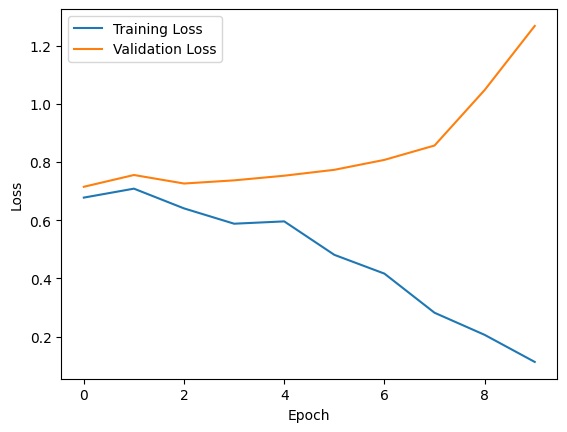

ACCURACY 256, 2, 0.001, 0.8, <class 'torch.optim.adam.Adam'>:  50.000%
Epoch [1/10], Loss: 0.72633, Val Acc: 52.94%
Epoch [2/10], Loss: 0.67429, Val Acc: 55.88%
Epoch [3/10], Loss: 0.48244, Val Acc: 55.88%
Epoch [4/10], Loss: 0.16454, Val Acc: 55.88%
Epoch [5/10], Loss: 0.01019, Val Acc: 55.88%
Epoch [6/10], Loss: 0.00021, Val Acc: 50.00%
Epoch [7/10], Loss: 0.00003, Val Acc: 47.06%
Epoch [8/10], Loss: 0.00002, Val Acc: 50.00%
Epoch [9/10], Loss: 0.00001, Val Acc: 47.06%
Epoch [10/10], Loss: 0.00001, Val Acc: 50.00%


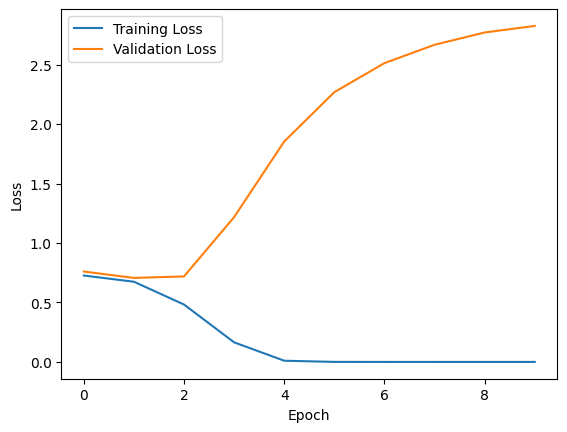

ACCURACY 256, 2, 0.002, 0.2, <class 'torch.optim.adam.Adam'>:  50.000%
Epoch [1/10], Loss: 0.68820, Val Acc: 52.94%
Epoch [2/10], Loss: 0.75416, Val Acc: 52.94%
Epoch [3/10], Loss: 0.56517, Val Acc: 44.12%
Epoch [4/10], Loss: 0.44324, Val Acc: 50.00%
Epoch [5/10], Loss: 0.19295, Val Acc: 44.12%
Epoch [6/10], Loss: 0.01793, Val Acc: 52.94%
Epoch [7/10], Loss: 0.00256, Val Acc: 58.82%
Epoch [8/10], Loss: 0.00115, Val Acc: 55.88%
Epoch [9/10], Loss: 0.00024, Val Acc: 52.94%
Epoch [10/10], Loss: 0.00008, Val Acc: 52.94%


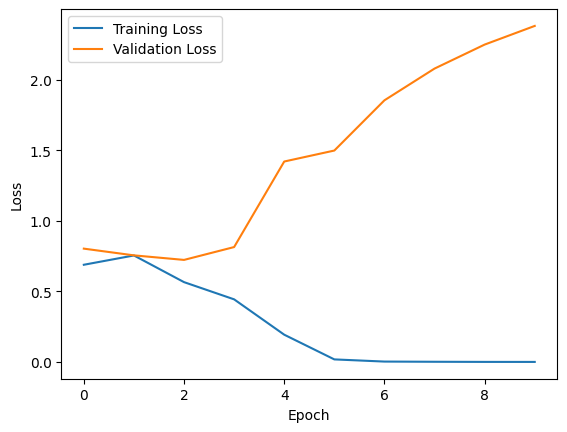

ACCURACY 256, 2, 0.002, 0.4, <class 'torch.optim.adam.Adam'>:  52.941%
Epoch [1/10], Loss: 0.70260, Val Acc: 52.94%
Epoch [2/10], Loss: 0.63509, Val Acc: 52.94%
Epoch [3/10], Loss: 0.51748, Val Acc: 44.12%
Epoch [4/10], Loss: 0.26717, Val Acc: 47.06%
Epoch [5/10], Loss: 0.07311, Val Acc: 44.12%
Epoch [6/10], Loss: 0.00782, Val Acc: 47.06%
Epoch [7/10], Loss: 0.00087, Val Acc: 50.00%
Epoch [8/10], Loss: 0.00910, Val Acc: 52.94%
Epoch [9/10], Loss: 0.01271, Val Acc: 50.00%
Epoch [10/10], Loss: 0.00056, Val Acc: 44.12%


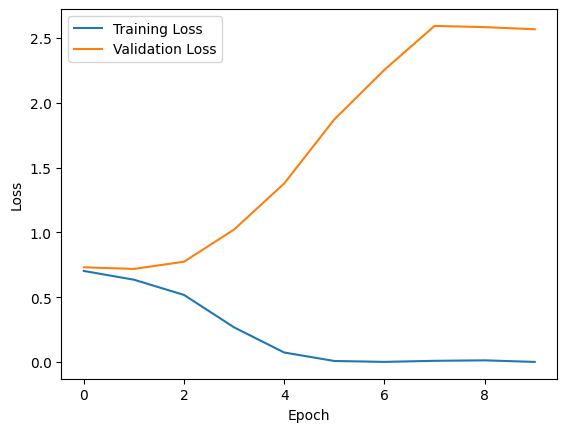

ACCURACY 256, 2, 0.002, 0.6, <class 'torch.optim.adam.Adam'>:  44.118%
Epoch [1/10], Loss: 0.75456, Val Acc: 52.94%
Epoch [2/10], Loss: 0.66096, Val Acc: 52.94%
Epoch [3/10], Loss: 0.61986, Val Acc: 52.94%
Epoch [4/10], Loss: 0.49392, Val Acc: 52.94%
Epoch [5/10], Loss: 0.44114, Val Acc: 52.94%
Epoch [6/10], Loss: 0.24584, Val Acc: 50.00%
Epoch [7/10], Loss: 0.18605, Val Acc: 47.06%
Epoch [8/10], Loss: 0.08841, Val Acc: 38.24%
Epoch [9/10], Loss: 0.09789, Val Acc: 50.00%
Epoch [10/10], Loss: 0.12721, Val Acc: 47.06%


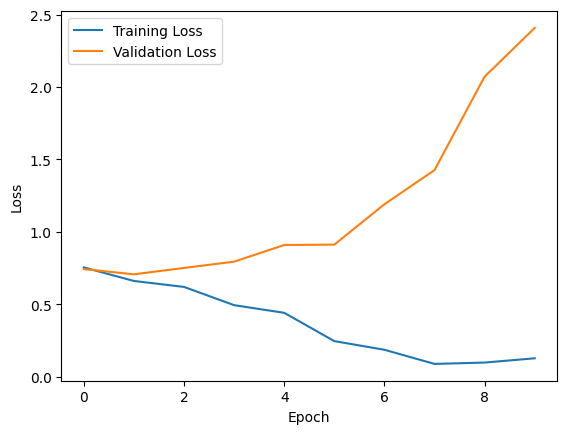

ACCURACY 256, 2, 0.002, 0.8, <class 'torch.optim.adam.Adam'>:  47.059%
Best Parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.002, 'dropout': 0.2, 'optim': <class 'torch.optim.adam.Adam'>}
Best Accuracy: 0.5588235294117647


In [7]:
param_grid = {
    'hidden_size': [128, 256],
    'num_layers': [2],
    'learning_rate': [0.001, 0.002],
    'dropout': [0.2, 0.4, 0.6, 0.8],
    'optim': [torch.optim.Adam]
}

best_accuracy = 0.0
best_params = {}

for hidden_size in param_grid['hidden_size']:
    for num_layers in param_grid['num_layers']:
        for learning_rate in param_grid['learning_rate']:
            for dropout in param_grid['dropout']:
                for optim in param_grid['optim']:
                    # print(f"TRAINING ON: hidsize {hidden_size}, numlayers {num_layers}, learnrate {learning_rate}")
                    accuracy = train_lstm(hidden_size, num_layers, learning_rate, dropout, optim)
                    print(f"ACCURACY {hidden_size}, {num_layers}, {learning_rate}, {dropout}, {optim}:  {accuracy:.3%}")
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {'hidden_size': hidden_size, 'num_layers': num_layers, 'learning_rate': learning_rate, 'dropout': dropout, 'optim': optim}

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [11]:
best_model = ezPzLSTM(input_size, best_params['hidden_size'], best_params['num_layers'], num_classes, best_params['dropout']).to(device)
criterion = nn.CrossEntropyLoss()
optim = best_params['optim']
optimizer = optim(best_model.parameters(), lr=best_params['learning_rate'])

combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=24, shuffle=True)

num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0

    for i, (x, y) in enumerate(combined_loader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        scores = best_model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_losses.append(running_loss / len(combined_loader))

test_losses = []
pred_y_test = []
true_y_test = []

best_model.eval()
with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device=device, dtype=torch.float32)
        test_y = test_y.to(device=device, dtype=torch.long)

        test_scores = best_model(test_x)
        _, preds = torch.max(test_scores, 1)
        test_loss = criterion(test_scores, test_y).item()

        test_losses.append(test_loss)

        if device == torch.device('cuda'):
            pred_y_test.extend(preds.cpu().numpy())
            true_y_test.extend(test_y.cpu().numpy())
        else:
            pred_y_test.extend(preds.numpy())
            true_y_test.extend(test_y.numpy())

test_accuracy = accuracy_score(true_y_test, pred_y_test)
average_test_loss = sum(test_losses) / len(test_losses)

print(f'Test Accuracy: {test_accuracy:.2%}')
print(f'Average Test Loss: {average_test_loss:.4f}')

Test Accuracy: 41.18%
Average Test Loss: 3.4082


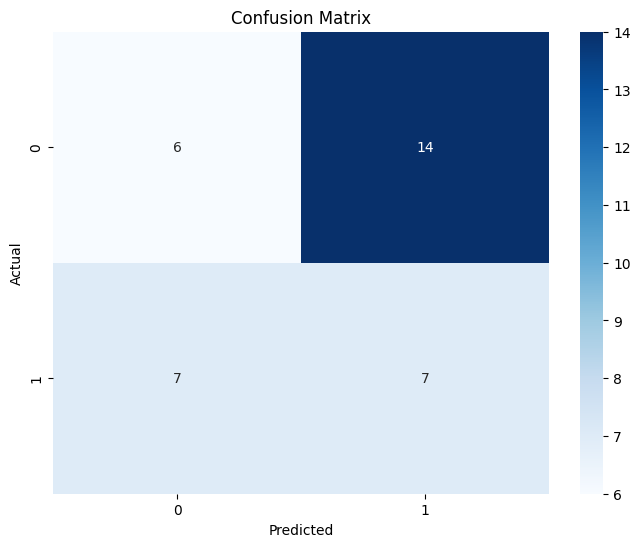

In [10]:
confusion = confusion_matrix(true_y_test, pred_y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [46]:
torch.save(best_model, './saved_models/bin_lstm.pth')

In [19]:
ezPiezo = ezPzLSTM
model = torch.load('./saved_models/bin_lstm.pth')
model.eval()

predicted_y = []
true_y = []
val_loss = 0
with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(device=device, dtype=torch.float32)
        val_y = val_y.to(device=device, dtype=torch.long)
        val_scores = model(val_x)
        _, preds = torch.max(val_scores, 1)
        val_scores = model(val_x)
        val_loss += criterion(val_scores, val_y).item()

        if device == torch.device('cuda'):
            predicted_y.extend(preds.cpu().numpy())
            true_y.extend(val_y.cpu().numpy())
        else:
            predicted_y.extend(preds.numpy())
            true_y.extend(val_y.numpy())
    
    val_accuracy = accuracy_score(true_y, predicted_y)
    print(f'Validation Accuracy: {val_accuracy:.2%}')

    average_val_loss = val_loss / len(val_loader)
    print(f'Average Validation Loss: {average_val_loss:.3f}')

Validation Accuracy: 70.59%
Average Validation Loss: 0.563


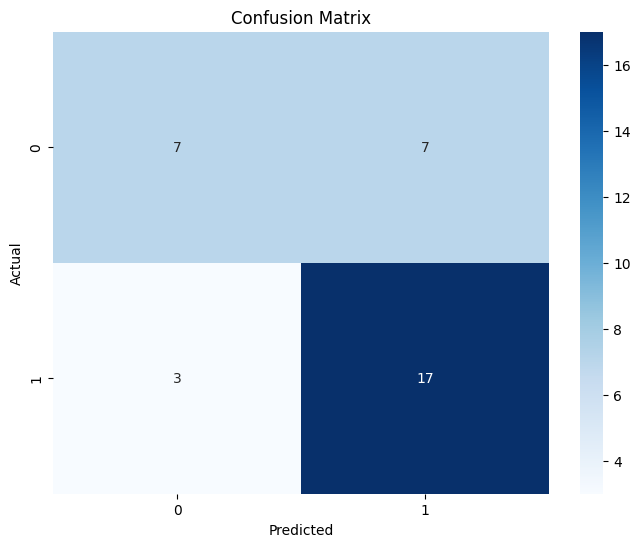

In [18]:
confusion = confusion_matrix(true_y, predicted_y)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Multi-class

In [5]:
train_m = "./data/train_multi.csv"
test_m = "./data/test_multi.csv"
val_m = "./data/val_multi.csv"
data_dir = "./data/raw/"

CROP = 12000
cut = lambda x: x[:CROP]

def stfourier(x):
    freq = len(x) // 3.0
    f, t, Zxx = stft(x[:, :CROP], fs=freq, nperseg=100, noverlap=50)
    return np.asarray([f, t, Zxx])

def fourier(x):
    t = x[0, :CROP]
    d = np.fft.fft(x[1, :CROP])
    return np.asarray([t, d])


train_dataset = pzNpz(train_m, data_dir, transform=fourier)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = pzNpz(test_m, data_dir, transform=fourier)
test_loader = DataLoader(test_dataset, batch_size=10)

val_dataset = pzNpz(val_m, data_dir, transform=fourier)
val_loader = DataLoader(val_dataset, batch_size=10)

In [6]:
# model parameters
input_size = CROP
hidden_size = 128
num_layers = 2
# classes: Major, minor, Major 7, minor 7
num_classes = 4

Validation Accuracy: 0.0
Epoch [1/10], Loss: 1.3961870272954304
Validation Accuracy: 0.0
Epoch [2/10], Loss: 1.3405459920565288
Validation Accuracy: 0.0
Epoch [3/10], Loss: 1.263542373975118
Validation Accuracy: 0.0
Epoch [4/10], Loss: 1.231119712193807
Validation Accuracy: 0.0
Epoch [5/10], Loss: 1.129360020160675
Validation Accuracy: 0.0
Epoch [6/10], Loss: 1.0404105981190999
Validation Accuracy: 0.25
Epoch [7/10], Loss: 0.9291208982467651
Validation Accuracy: 0.25
Epoch [8/10], Loss: 0.7920613785584768
Validation Accuracy: 0.25
Epoch [9/10], Loss: 0.648011177778244
Validation Accuracy: 0.5
Epoch [10/10], Loss: 0.5167776644229889


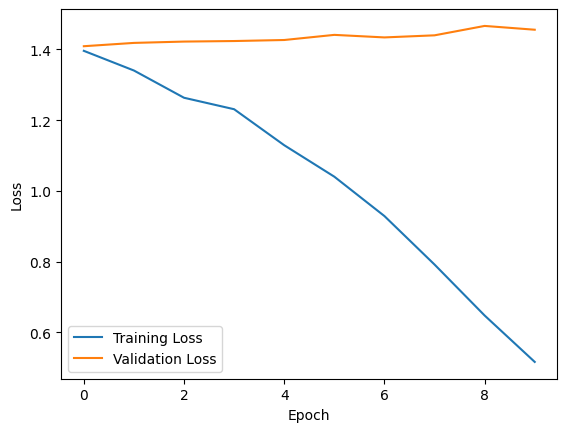

In [12]:
model = ezPzLSTM(input_size, hidden_size, num_layers, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

num_epochs = 10

train_losses = []
val_losses = []
predicted_y = []
true_y = []

# device = torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_losses.append(running_loss / len(train_loader))

    model.eval()

    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device=device, dtype=torch.float32)
            val_y = val_y.to(device=device, dtype=torch.long)
            val_scores = model(val_x)
            _, preds = torch.max(val_scores, 1)
            val_scores = model(val_x)
            val_loss += criterion(val_scores, val_y).item()

        if device == torch.device('cuda'):
            predicted_y.extend(preds.cpu().numpy())
            true_y.extend(val_y.cpu().numpy())
        else:
            predicted_y.extend(preds.numpy())
            true_y.extend(val_y.numpy())
        
        val_accuracy = accuracy_score(true_y, predicted_y)
        print(f'Validation Accuracy: {val_accuracy:.2%}')

        avg_val_loss = val_loss / len(val_loader)
        print(f'Average Validation Loss: {average_val_loss:.4f}')

        val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.5f}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

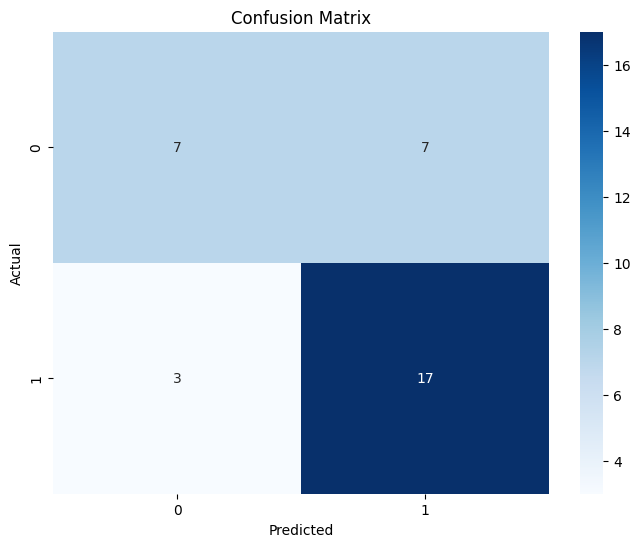

In [32]:
confusion = confusion_matrix(true_y, predicted_y)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()